## Replace BG Study

## Data

### Files & Relvant Columns

#### Files

The study data folder is named **Loop study public dataset 2023-01-31**

From the ReadMe.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

| File Name| Description| Note|
|------|-----|-----|
| HDeviceCGM,.txt| One record per CGM reading | Similar to what we've seen in Loop (Tidepool structure) |
| HDeviceBasal.txt| | Not included in the JAEB file anymore. Similar to what we've seen in Loop (Tidepool structure)|
| HDeviceBolus.txt| One record per bolus reading from a pump | Similar to what we've seen in Loop (Tidepool structure)|
| HPtRoster.txt|One record per Protocol H PtID obtained |  |

#### Relevant Columns:
The following lists all relevant columns. Other columns were considered irrelevant. Some are still mentioned if they serve the discussion but crossed through.

#### HDeviceCGM.txt
| Field_Name | Description (Glossary) | Notes |
|----|----|-|
| DeviceDtTmDaysFromEnroll | Device date number of days from enrollment| convert to timedelta (unit='days'), add to DeviceTm and arbitrary study start date|
| DeviceTm |Device time | convert to timedelta (H::M:S)|
|DexInternalDtTmDaysFromEnroll|Internal date number of days from enrollment| Seems to be Dexcom time, Not missing as in Loop, let's check if needed.|
|DexInternalTm|Internal time|Seems to be Dexcom time, Not missing as in Loop, let's check if needed.|
| RecordType| Type of data (CGM, Calibration, etc)| Needed to drop calibrations|
| GlucoseValue| Glucose value (units: mg/dL)| |

#### HDeviceBolus.txt
| Field_Name| Description (Glossary) | Notes |
|-|-|-|
| DeviceDtTmDaysFromEnroll | Device date number of days from enrollment| convert to timedelta (unit='days'), add to DeviceTm and arbitrary study start date|
| DeviceTm |Device time | convert to timedelta (H::M:S)|
| BolusType| Subtype of data (ex: "Normal" and "Square" are subtypes of "Bolus" type)||
| Normal | Number of units of normal bolus |Likely the only relevant value.|
| Extended | Number of units for extended delivery | We found that there are 0.4% extended boluses, probably triggered from the pump directly since Loop does not support these.|
| Duration | Time span over which the bolus was delivered (milliseconds for Tidepool data, minutes for Diasend data) | Our analysis shows that Duration refers to the Extended part of a Bolus. However, unclear how to find out wether in ms or minutes. JAEB couldn't answer.|

#### HDeviceBasal.txt
Note: File not included in the JAEB file anymore!

| Field_Name | Description (Glossary) |  Notes|
|--|---|--|
| PtID |  Participant ID | |
| DeviceDtTmDaysFromEnroll | Device date number of days from enrollment| convert to timedelta (unit='days'), add to DeviceTm and arbitrary study start date|
| DeviceTm |Device time | convert to timedelta (H::M:S)|
| BasalType| Basal delivery type|used to find suspends|
| Duration | Actual number of milliseconds basal will be in effect| Used as duration|
| Rate | Number of units per hour |We use this as actual delivery rate|

Note: As in the Loop study dataset, we assume that the Bolus columns: ExpectedNormal, ExpectedDuration, ExpectedExtended (Bolus) and the Basal columns: ExpectedDuration, Percent, SuprBasalType, SuprDuration, SuprRate can be ignored as they don't represent the actual deliveries but amounts that were suppressed. However, we will use them to investigate duplicates.

#### Summary
The tables mostly follow the Tidepool structure 
Differences:
- Timestamps are given relative to enrollment start
- Insulin and InsValue columns exist, however always empty
- CGM values in mgdl not mmol
- Dexcom times seem to be present in all rows
- No timezone offsets are present, probably all in local time

#TODO:
 1. Check if Dexcom times exist and if they are needed
 2. Check if duration is in milliseconds (Bolus)

In [1]:
import os, sys
from datetime import datetime, timedelta, timezone
import time
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(),'..','..'))
from src import pandas_helper, cdf, tdd, drawing
import importlib

def save_figure(name):
   path = os.path.join(os.getcwd(), '..','..','docs','data_sets','assets',f'replacebg_{name}.png')
   plt.savefig(path)

## Load data

In [20]:
#define path variables
study_name = 'REPLACE-BG Dataset-79f6bdc8-3c51-4736-a39f-c4c0f71d45e5'
raw_path = os.path.join(os.getcwd(), '..', '..', 'data', 'raw')
out_path = os.path.join(os.getcwd(), '..', '..', 'data', 'out')
study_path = os.path.join(raw_path, study_name)
df_basal = pd.read_csv(os.path.join(study_path, 'Data Tables', 'HDeviceBasal.txt'), sep='|')
df_bolus = pd.read_csv(os.path.join(study_path, 'Data Tables', 'HDeviceBolus.txt'), sep='|')
df_patient = pd.read_csv(os.path.join(study_path, 'Data Tables', 'HPtRoster.txt'), sep='|')
df_uploads = pd.read_csv(os.path.join(study_path, 'Data Tables', 'HDeviceUploads.txt'), sep='|')
df_cgm = pd.read_csv(os.path.join(study_path, 'Data Tables', 'HDeviceCGM.txt'), sep='|')

### Uniqe Patients

In [21]:
from functools import reduce

#number of unique patients
print(f"There are {df_patient['PtID'].nunique()} unique patients in the patient roster")
print(f"There are {df_bolus['PtID'].nunique()} unique patients in the bolus table")
print(f"There are {df_basal['PtID'].nunique()} unique patients in the basal table")
print(f"There are {df_cgm['PtID'].nunique()} unique patients in the cgm table")

#interscetion
unique_overall = reduce(np.intersect1d, [df_cgm['PtID'].unique(), 
                                         df_bolus['PtID'].unique(), 
                                         df_basal['PtID'].unique(),
                                         df_patient['PtID'].unique(),
                                         df_uploads['PtId'].unique()])
print(f"There are {len(unique_overall)} patients in all tables")

There are 226 unique patients in the patient roster
There are 224 unique patients in the bolus table
There are 208 unique patients in the basal table
There are 226 unique patients in the cgm table
There are 208 patients in all tables


In [22]:
#drop patients not in all tables
df_bolus = df_bolus[df_bolus['PtID'].isin(unique_overall)]
df_basal = df_basal[df_basal['PtID'].isin(unique_overall)]
df_cgm = df_cgm[df_cgm['PtID'].isin(unique_overall)]
df_patient = df_patient[df_patient['PtID'].isin(unique_overall)]
df_uploads = df_uploads[df_uploads['PtId'].isin(unique_overall)]

### Days since enrollment

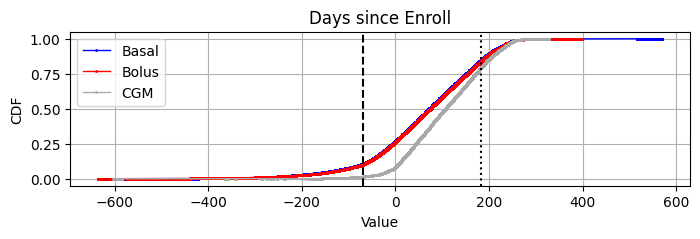

In [23]:
plt.figure(figsize=(8,2)); ax=plt.gca()
cdf.plot_cdf(df_basal.DeviceDtTmDaysFromEnroll,ax=ax,color=drawing.colors['Basal'],label='Basal')
cdf.plot_cdf(df_bolus.DeviceDtTmDaysFromEnroll,ax=ax,color=drawing.colors['Bolus'],label='Bolus')
cdf.plot_cdf(df_cgm.DeviceDtTmDaysFromEnroll,ax=ax,color=drawing.colors['CGM'],label='CGM')
ax.legend()
ax.axvline(-10*7, color='black', linestyle='--', label='run-in (max 10 week before enrollment)');
ax.axvline(26*7, color='black', linestyle=':', label='study end (max 26 weeks after enrollment)');
plt.title('Days since Enroll')
save_figure('DeviceDtTmDaysFromEnroll')

### Datapoints per patient

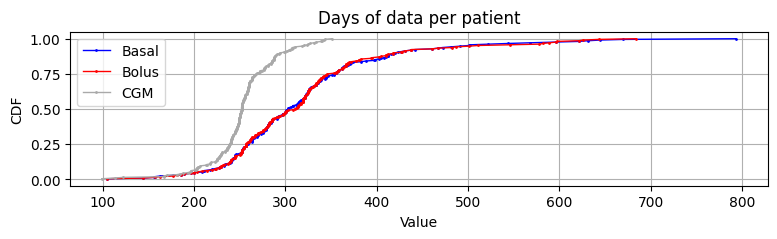

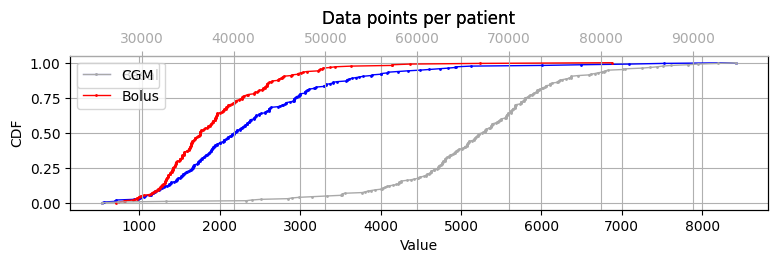

In [24]:
#number of datapoints per patient
import importlib
importlib.reload(cdf)
#days per patient
plt.figure(figsize=(9,2)); ax=plt.gca()
cdf.plot_cdf(df_basal.groupby('PtID')['DeviceDtTmDaysFromEnroll'].nunique(),ax=ax, color=drawing.colors['Basal']); 
cdf.plot_cdf(df_bolus.groupby('PtID')['DeviceDtTmDaysFromEnroll'].nunique(),ax=ax, color=drawing.colors['Bolus']); 
cdf.plot_cdf(df_cgm.groupby('PtID')['DeviceDtTmDaysFromEnroll'].nunique(),ax=ax, color=drawing.colors['CGM']); 
plt.legend(['Basal','Bolus','CGM']); plt.title('Days of data per patient')

#datapoints
plt.figure(figsize=(9,2)); ax=plt.gca()
cdf.plot_cdf(df_basal.groupby('PtID').size(),ax=ax, color=drawing.colors['Basal']); 
cdf.plot_cdf(df_bolus.groupby('PtID').size(),ax=ax, color=drawing.colors['Bolus']);
plt.legend(['Basal','Bolus']); plt.title('Data points per patient')
twiny = ax.twiny()
cdf.plot_cdf(df_cgm.groupby('PtID').size(),ax=twiny, color=drawing.colors['CGM']);
plt.legend(['CGM']); plt.title('Data points per patient')
twiny.spines['top'].set_color(drawing.colors['CGM'])
twiny.xaxis.label.set_color(drawing.colors['CGM'])
twiny.set_xlabel('')
#twiny.set_xlabel('Data points per patient')
twiny.tick_params(axis='x', colors=drawing.colors['CGM'])

## Datetimes

In [25]:
#convert datetimes and durations
enrollment_start = datetime(2015,1,1)
df_basal['datetime'] = enrollment_start+pd.to_timedelta(df_basal['DeviceDtTmDaysFromEnroll'],unit='D')+pd.to_timedelta(df_basal['DeviceTm'])
df_bolus['datetime'] = enrollment_start+pd.to_timedelta(df_bolus['DeviceDtTmDaysFromEnroll'],unit='D')+pd.to_timedelta(df_bolus['DeviceTm'])
df_cgm['datetime'] = enrollment_start+pd.to_timedelta(df_cgm['DeviceDtTmDaysFromEnroll'],unit='D')+pd.to_timedelta(df_cgm['DeviceTm'])

df_basal['hour_of_day'] = df_basal.datetime.dt.hour
df_bolus['hour_of_day'] = df_bolus.datetime.dt.hour
df_cgm['hour_of_day'] = df_cgm.datetime.dt.hour

df_bolus['day'] = df_bolus.datetime.dt.date
df_basal['day'] = df_basal.datetime.dt.date
df_cgm['day'] = df_cgm.datetime.dt.date


#drop DeviceDtTmDaysFromEnroll and DeviceTm
df_basal.drop(columns=['DeviceDtTmDaysFromEnroll', 'DeviceTm'], inplace=True)
df_bolus.drop(columns=['DeviceDtTmDaysFromEnroll', 'DeviceTm'], inplace=True)
df_cgm.drop(columns=['DeviceDtTmDaysFromEnroll', 'DeviceTm'], inplace=True)

To check consistency, let's look at a cgm trace for three days:

Patient: 205, Start: 2015-06-10 10:43:30, End: 2015-06-13 10:43:30


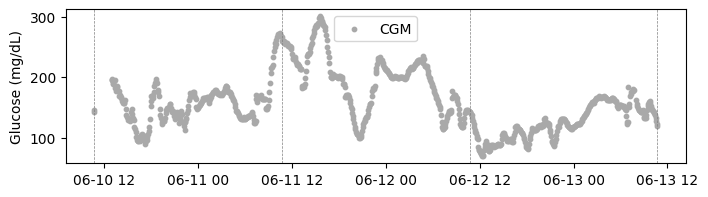

In [26]:
sample = df_cgm.sample()
patient_id = sample.PtID.values[0]
start = pd.to_datetime(sample.datetime.values[0])
end = start+timedelta(days=3)
print(f'Patient: {patient_id}, Start: {start}, End: {end}')
sub_frame = df_cgm.loc[(df_cgm.PtID==patient_id) & (df_cgm.datetime>=start) & (df_cgm.datetime<=end)]
importlib.reload(drawing)
plt.figure(figsize=(8,2)); ax=plt.gca()
drawing.drawCGM(ax,sub_frame.datetime,sub_frame.GlucoseValue)
for single_date in pd.date_range(start=start, end=end):
    ax.axvline(single_date, color='grey', linestyle='--', linewidth=0.5)

save_figure('CGM_example')

#### Sort

In [27]:
## sort
df_basal.sort_values(by=['PtID','datetime'], inplace=True)
df_bolus.sort_values(by=['PtID','datetime'], inplace=True)
df_cgm.sort_values(by=['PtID','datetime'], inplace=True)

## Durations
From the glossary we know that diasend durations are given in minutes instead of ms as in Tidepool

#### Handle Diasend Source

Merge the data source information into the bolus and basal tables. For cgm, it has no relevance for us.

In [28]:
#add DataSource to bolus and basal
#bolus
temp = df_uploads.rename(columns={'PtId':'PtID','RecID':'ParentHDeviceUploadsID'})
df_bolus = pd.merge(df_bolus, temp[['PtID','ParentHDeviceUploadsID','DataSource']],
         on=['PtID','ParentHDeviceUploadsID'],how='inner')

#basal
temp = df_uploads.rename(columns={'PtId':'PtID','RecID':'ParentHDeviceUploadsID'})
df_basal = pd.merge(df_basal, temp[['PtID','ParentHDeviceUploadsID','DataSource']],
         on=['PtID','ParentHDeviceUploadsID'],how='inner')

In [29]:
#display data source counts
display("Bolus:")
display(df_bolus.DataSource.value_counts())

display("Basal:")
display(df_basal.DataSource.value_counts())

'Bolus:'

DataSource
Tidepool    402666
Diasend        746
Name: count, dtype: int64

'Basal:'

DataSource
Tidepool    504017
Name: count, dtype: int64

Only boluses are affected. Let's check how many extended parts are affected and if the duraitons are really in minutes.

BolusType
Normal         742
Combination      4
Name: count, dtype: int64

'Extended'

,BolusType,NaN Count,Non-NaN Count,Zero Count
0,Combination,0,4,0
1,Normal,742,0,0


BolusType
Combination    4
Name: count, dtype: int64

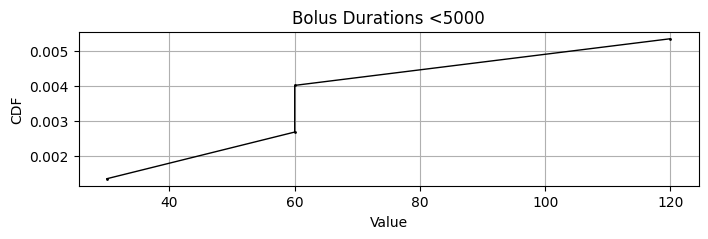

In [30]:
#Diasend Boluses

df_diasend = df_bolus.loc[df_bolus.DataSource=='Diasend']
display(df_diasend.BolusType.value_counts())

#display nan and null counts for extended boluses
display('Extended')
display(pandas_helper.grouped_value_counts(df_diasend,['BolusType'],'Extended'))

#display diasend durations
display(df_diasend.dropna(subset='Duration').BolusType.value_counts())
cdf.plot_cdf(df_diasend.Duration, title='Bolus Durations <5000')

save_figure('Bolus_Duration_Diasend')

#### Summary Diasend
 - There are no Diasend Basals
 - all diasend boluses are 'Combination boluses' or Normal Boluses
 - all Combination boluses have a duration (**in minutes**)
 - But only 4 out of 1060 have an extended aprt

Given that some of them have an extended part it seems more logical that the extended part is missing for the others.

Therefore we treat Diasend imports as follows:
1. Adjust from minutes to milliseconds
2. Set Duration to 0 when extended part is missing


### Convert to timedeltas

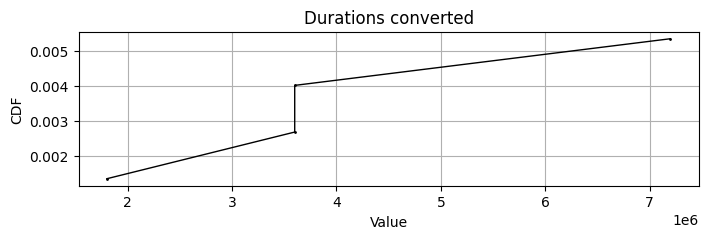

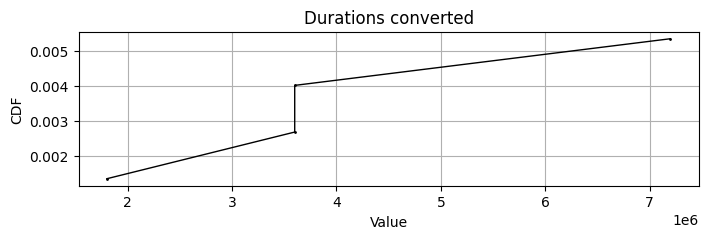

In [ ]:
#conver durations to timedelta (+ account for diasend)

#adjust diasend duration 
#convert diasend from minute to ms
df_bolus.loc[df_bolus.DataSource=='Diasend','Duration'] *= 60*1000
#Treat diasend boluses without extended aprt as normal boluses (set duration to nan)
df_bolus.loc[(df_bolus.DataSource=='Diasend') & df_bolus.Extended.isna() & df_bolus.Duration.notna(),['Duration']] = np.nan

#convert duraitons to timedeltas
df_basal['Duration'] = pd.to_timedelta(df_basal['Duration'],unit='ms')
df_basal['ExpectedDuration'] = pd.to_timedelta(df_basal['ExpectedDuration'],unit='ms')
df_basal['SuprDuration'] = pd.to_timedelta(df_basal['SuprDuration'],unit='ms')
df_bolus['Duration'] = pd.to_timedelta(df_bolus['Duration'],unit='ms')
df_bolus['ExpectedDuration'] = pd.to_timedelta(df_bolus['ExpectedDuration'],unit='ms')

## Explore Data Hierachy and Missing Data

- Check for Null Values
- Check bolus and basal types and cgm types
- calculate value_counts 

This can help us understand how the data is structured or reveal problems we haven't seen before.

### Value Counts

In [32]:
#Value Counts (%)
display('Basal Types  (%):')
display(100*df_basal.value_counts(subset=['BasalType'],dropna=False)/df_basal.shape[0])

display('Suspend Rate Values (%):')
display(df_basal.loc[df_basal.BasalType=='suspend'].Rate.value_counts(dropna=False))

display('Bolus Types (%):')
display(100*df_bolus.value_counts(subset=['BolusType'],dropna=False)/df_bolus.shape[0])

display('CGM Types (%):')
display(100*df_cgm.value_counts(subset=['RecordType'],dropna=False)/df_cgm.shape[0])

'Basal Types  (%):'

BasalType
scheduled    84.063831
suspend       8.069371
temp          7.866798
Name: count, dtype: float64

'Suspend Rate Values (%):'

Rate
NaN    40671
Name: count, dtype: int64

'Bolus Types (%):'

BolusType  
normal         94.424063
dual/square     4.120106
square          1.270909
Normal          0.183931
Combination     0.000992
Name: count, dtype: float64

'CGM Types (%):'

RecordType 
CGM            99.047754
Calibration     0.952246
Name: count, dtype: float64

**Summary:**
- Very similar structure as Loop Dataset
- More suspends (8%) (all NaN), need to be filled with zero and checked if durations match
- CGM calibrations need to be dropped

### drop CGM Calibrations

In [33]:
df_cgm = df_cgm.loc[df_cgm.RecordType == 'CGM']

### Data Availability
Here we check which column hold values 

In [34]:
#column counts  (%)
display('Bolus:')
display(100*df_bolus.count()/len(df_bolus))
display('Basal:')
display(100*df_basal.count()/len(df_basal))
display('CGM:')
display(100*df_cgm.count()/len(df_cgm))

'Bolus:'

RecID                     100.000000
ParentHDeviceUploadsID    100.000000
PtID                      100.000000
SiteID                    100.000000
BolusType                 100.000000
InjValue                    0.000000
Insulin                     0.000000
Normal                     98.729091
ExpectedNormal              1.161840
Extended                    5.392006
ExpectedExtended            0.366375
Duration                    5.392006
ExpectedDuration            0.366375
datetime                  100.000000
hour_of_day               100.000000
day                       100.000000
DataSource                100.000000
dtype: float64

'Basal:'

RecID                     100.000000
ParentHDeviceUploadsID    100.000000
PtID                      100.000000
SiteID                    100.000000
BasalType                 100.000000
Duration                   99.916074
ExpectedDuration           16.879589
Percnt                      6.147610
Rate                       91.929439
SuprBasalType              12.718023
SuprDuration               11.322436
SuprRate                   12.710484
datetime                  100.000000
hour_of_day               100.000000
day                       100.000000
DataSource                100.000000
dtype: float64

'CGM:'

RecID                            100.000000
ParentHDeviceUploadsID           100.000000
PtID                             100.000000
SiteID                           100.000000
DexInternalDtTmDaysFromEnroll     95.680613
DexInternalTm                     95.680613
RecordType                       100.000000
GlucoseValue                     100.000000
datetime                         100.000000
hour_of_day                      100.000000
day                              100.000000
dtype: float64

Findings:
 - Most data exists
 - Number of Extended and Duration don't match exactly 
    - Some extended boluses likely come without a normal part
 - Many basal rows have no Rate value (nan) why is that?
 

In [35]:
importlib.reload(pandas_helper)
pandas_helper.grouped_value_counts(df_basal, ['BasalType'],'Rate')

,BasalType,NaN Count,Non-NaN Count,Zero Count
0,scheduled,0,423696,101
1,suspend,40671,0,0
2,temp,6,39644,5868


We see that basal rates are NaN when the basal type is suspend. This is true for all suspend events without exception. Therefore, we need to replace NaNs with zeros.

#### Replace Suspend NaNs with 0

In [36]:
df_basal.loc[df_basal.Rate.isna()].head()[['PtID','datetime','Rate','BasalType']]

,PtID,datetime,Rate,BasalType
13,2,2014-09-05 10:02:56,NaN,suspend
15,2,2014-09-05 10:04:47,NaN,suspend
17,2,2014-09-05 10:06:32,NaN,suspend
19,2,2014-09-05 11:04:56,NaN,suspend
22,2,2014-09-06 18:07:26,NaN,suspend


In [37]:
df_basal.fillna({'Rate':0}, inplace=True)

## Duplicates

#### Drop Actual Duplicates

In [38]:
### duplicates (all rows)
print(f"{df_bolus.duplicated(subset=['PtID', 'datetime','BolusType','Normal','Extended','Duration'],keep=False).sum()} actual duplicates in bolus")
print(f"{df_basal.duplicated(subset=['PtID', 'datetime','Rate','BasalType','Duration'],keep=False).sum()} actual duplicates in basal")
print(f"{df_cgm.duplicated(subset=['PtID', 'datetime','RecordType','GlucoseValue'],keep=False).sum()} actual duplicates in cgm")

#drop these duplicates
df_bolus = df_bolus.drop_duplicates(subset=['PtID', 'datetime','BolusType','Normal','Extended','Duration'])
df_basal = df_basal.drop_duplicates(subset=['PtID', 'datetime','Rate','BasalType','Duration'])
df_cgm = df_cgm.drop_duplicates(subset=['PtID', 'datetime','RecordType','GlucoseValue'])

8260 actual duplicates in bolus
104091 actual duplicates in basal
1840 actual duplicates in cgm


#### Temporal Duplicates

In [39]:
### Temporal duplicates (only on datetime)
print(f"{100*df_basal.duplicated(subset=['PtID', 'datetime'],keep=False).sum()/len(df_basal):.2f}% temporal duplicates in basal")
print(f"{100*df_bolus.duplicated(subset=['PtID', 'datetime'],keep=False).sum()/len(df_bolus):.2f}% temporal duplicates in bolus")
print(f"{100*df_cgm.duplicated(subset=['PtID', 'datetime'],keep=False).sum()/len(df_cgm):.2f}% temporal duplicates in cgm")

1.13% temporal duplicates in basal
0.00% temporal duplicates in bolus
0.01% temporal duplicates in cgm


Given the **low percentage of bolus and cgm duplicates**, no further investigation is done on that end. We resolve bolus and cgm dupciates using pandas .drop_duplicates(). 

**However**: While basal duplicates with 1% are still very few, we will take a closer look.

#### Basal Duplicates

In [40]:
#number of duplicates by combinations
print(f"{len(df_basal.loc[df_basal.duplicated(subset=['PtID', 'datetime'], keep=False)])} basal rows are datetime duplicates")
print(f"{len(df_basal.loc[df_basal.duplicated(subset=['PtID', 'datetime','Duration'], keep=False)])} basal rows are datetime and duration duplicates")
print(f"{len(df_basal.loc[df_basal.duplicated(subset=['PtID', 'datetime','Rate'], keep=False)])} basal rows are datetime and rate duplicates")
print(f"{len(df_basal.loc[df_basal.duplicated(subset=['PtID', 'datetime','Duration','Rate'], keep=False)])} basal rows are datetime, duration and rate duplicates")

5112 basal rows are datetime duplicates
1624 basal rows are datetime and duration duplicates
2622 basal rows are datetime and rate duplicates
106 basal rows are datetime, duration and rate duplicates


##### Inspecting Duplicates and surrounding Events

In [41]:
import ipywidgets as widgets
from IPython.display import display
import importlib

importlib.reload(pandas_helper)

# Define available columns for duplicates selection
available_columns = [
    ('datetime', True), 
    ('Duration', True), 
    ('Rate', False)
]

column_selector = widgets.HBox([
    widgets.Checkbox(value=default, description=col) for col, default in available_columns
])


def get_selected_columns():
    return [cb.description for cb in column_selector.children if cb.value]

basal_temp_dups = df_basal.loc[df_basal.duplicated(subset=['PtID', 'datetime'])]
def update_duplicates(*args):
    global basal_temp_dups
    selected_columns = get_selected_columns()
    basal_temp_dups = df_basal.loc[df_basal.duplicated(subset=['PtID'] + selected_columns, keep=False)]
    slider.max = max(len(basal_temp_dups) - 1, 0)
    slider.value = slider.value


# Attach update function to selection change
for cb in column_selector.children:
    cb.observe(update_duplicates, names='value')

# Create slider
slider = widgets.IntSlider(min=0, max=max(len(basal_temp_dups) - 1, 0), step=1, description='Index')

# Initial duplicate detection
update_duplicates()


# Scroll through the duplicates and get the surrounding rows
def display_surrounding_rows(i, parent_df, df):
    if len(df) == 0:
        print("No duplicates found based on selected columns.")
        return
    index = df.index[i]
    subframe = pandas_helper.extract_surrounding_rows(parent_df, index, 2, sort_by=['PtID', 'datetime'])
    subframe['end'] = subframe['datetime'] + subframe['Duration']
    subframe = subframe[['PtID', 'BasalType', 'RecID', 'datetime', 'Duration', 'end', 'Rate']]
    display(subframe)


# Create buttons
prev_button = widgets.Button(description="<")
next_button = widgets.Button(description=">")


# Button event handlers
def on_button_clicked(b):
    if b.description == "<":
        slider.value = max(slider.value - 1, slider.min)
    elif b.description == ">":
        slider.value = min(slider.value + 1, slider.max)


# Attach event handlers
prev_button.on_click(on_button_clicked)
next_button.on_click(on_button_clicked)

slider_controls = widgets.HBox([prev_button, slider, next_button])
out = widgets.interactive_output(display_surrounding_rows, {'i': slider, 'parent_df': widgets.fixed(df_basal), 'df': widgets.fixed(basal_temp_dups)})

# Display the UI
display(column_selector, slider_controls, out)

Output()

In [42]:
print('This is where they differ:')
display(pandas_helper.count_differences_in_duplicates(df_basal, subset=['PtID', 'datetime']))

#print some temporal duplicates
display("some examples:")
display(df_basal.loc[[301126,301125,166899,166901,166903,166927,166928],['PtID', 'datetime', 'Duration','ExpectedDuration', 'Rate','BasalType','Percnt','SuprDuration','SuprRate']])

This is where they differ:


RecID                     2539
ParentHDeviceUploadsID    1925
PtID                         0
SiteID                       0
BasalType                 1236
Duration                  1727
ExpectedDuration          2071
Percnt                     197
Rate                      1250
SuprBasalType             1220
SuprDuration              1119
SuprRate                  1222
datetime                     0
hour_of_day                  0
day                          0
DataSource                   0
dtype: int64

'some examples:'

,PtID,datetime,Duration,ExpectedDuration,Rate,BasalType,Percnt,SuprDuration,SuprRate
301126,171,2015-02-16 00:00:00,0 days 04:00:00,NaT,0.75,scheduled,NaN,NaT,NaN
301125,171,2015-02-15 17:00:00,0 days 07:00:00,NaT,0.75,scheduled,NaN,NaT,NaN
166899,96,2015-07-06 06:39:25,0 days 00:04:32,NaT,0.00,suspend,NaN,NaT,NaN
166901,96,2015-07-06 11:04:11,0 days 12:55:49,NaT,0.95,scheduled,NaN,NaT,NaN
166903,96,2015-07-07 00:01:52,0 days 04:01:53,NaT,0.85,scheduled,NaN,NaT,NaN
166927,96,2015-07-10 07:37:00,0 days 00:01:17,NaT,1.15,scheduled,NaN,NaT,NaN
166928,96,2015-07-10 07:38:17,0 days 00:03:12,NaT,0.00,suspend,NaN,NaT,NaN


It looks like 
 - sometimes we see duplicates in all relevant columns
 - often we could argue that the suspendevents overwrite the scheduled event
 - sometimes, the durations are empty
 - sometimes there are different durations, and only one matches the next valid row
 

##### Equal duration & rate
When we have duplicates where datetime, duration and rate are equal, we don't care which one, we just keep one:


In [43]:
#obvious: duplicates: equal duration and rate
temp = df_basal.loc[df_basal.duplicated(subset=['PtID', 'datetime','Rate','Duration'],keep=False)]
temp = temp.sort_values(by=['PtID', 'datetime'])
display(temp[['PtID','datetime','Rate','Duration','BasalType','Percnt','SuprDuration','SuprRate']].head(4))

print(f"From all duplicates in basal, {100*len(temp)/len(basal_temp_dups):.2f}% are duplicates in rate and duration")
display(temp.BasalType.value_counts())

,PtID,datetime,Rate,Duration,BasalType,Percnt,SuprDuration,SuprRate
2,2,2014-09-01,0.108,1 days,scheduled,NaN,NaT,NaN
3,2,2014-09-01,0.108,1 days,temp,0.12,NaT,0.9
4,2,2014-09-02,0.108,1 days,scheduled,NaN,NaT,NaN
5,2,2014-09-02,0.108,1 days,temp,0.12,NaT,0.9


From all duplicates in basal, 6.53% are duplicates in rate and duration


BasalType
scheduled    53
temp         53
Name: count, dtype: int64

In [44]:
#drop
#df_basal = df_basal.drop_duplicates(subset=['PtID', 'datetime','Rate', 'Duration'],keep='first')
#basal_temp_dups = df_basal.loc[df_basal.duplicated(subset=['PtID','datetime'], keep=False)]
#print(f"{len(basal_temp_dups)} temporal duplicates are left after removing duplicates in rate and duration")

##### Equal duration, different rate
Some duplicates have the same duration. Then the question is which one to pick:

In [45]:
basal_temp_dur_dups = df_basal.loc[df_basal.duplicated(subset=['PtID', 'datetime', 'Duration'],keep=False)]
basal_temp_dur_dups_grped = basal_temp_dur_dups.groupby(['PtID', 'datetime','Duration'],group_keys=False)

print('These are the combinations:')
combinations = basal_temp_dur_dups_grped.apply(lambda x: set(x.BasalType), include_groups=False)
display(combinations.value_counts())

#print examples for each combination
for aset in combinations.value_counts().index:
    display(f'Examples for {aset}:')
    temp = basal_temp_dur_dups_grped.filter(lambda g: set(g['BasalType']) == aset)
    display(temp.head(4)[['PtID','datetime','Rate','Duration','BasalType','Percnt','SuprDuration','SuprRate']])

These are the combinations:


{suspend, scheduled}    689
{scheduled, temp}       103
{scheduled}              17
{suspend, temp}           3
Name: count, dtype: int64

"Examples for {'suspend', 'scheduled'}:"

,PtID,datetime,Rate,Duration,BasalType,Percnt,SuprDuration,SuprRate
40548,24,2015-02-26 18:00:00,1.2,0 days 06:00:00,scheduled,NaN,NaT,NaN
40549,24,2015-02-26 18:00:00,0.0,0 days 06:00:00,suspend,NaN,0 days 06:00:00,1.1
40556,24,2015-02-27 03:00:00,0.9,0 days 03:00:00,scheduled,NaN,NaT,NaN
40557,24,2015-02-27 03:00:00,0.0,0 days 03:00:00,suspend,NaN,0 days 03:00:00,0.9


"Examples for {'scheduled', 'temp'}:"

,PtID,datetime,Rate,Duration,BasalType,Percnt,SuprDuration,SuprRate
2,2,2014-09-01,0.108,1 days,scheduled,NaN,NaT,NaN
3,2,2014-09-01,0.108,1 days,temp,0.12,NaT,0.9
4,2,2014-09-02,0.108,1 days,scheduled,NaN,NaT,NaN
5,2,2014-09-02,0.108,1 days,temp,0.12,NaT,0.9


"Examples for {'scheduled'}:"

,PtID,datetime,Rate,Duration,BasalType,Percnt,SuprDuration,SuprRate
310537,173,2015-01-30 00:00:00,0.900,0 days 05:00:00,scheduled,NaN,NaT,NaN
310538,173,2015-01-30 00:00:00,0.850,0 days 05:00:00,scheduled,NaN,NaT,NaN
331507,185,2015-07-14 20:30:00,0.025,0 days 03:30:00,scheduled,NaN,NaT,NaN
331508,185,2015-07-14 20:30:00,3.000,0 days 03:30:00,scheduled,NaN,NaT,NaN


"Examples for {'suspend', 'temp'}:"

,PtID,datetime,Rate,Duration,BasalType,Percnt,SuprDuration,SuprRate
41056,24,2015-03-28 03:00:00,0.45,0 days 03:00:00,temp,0.5,0 days 03:00:00,0.9
41057,24,2015-03-28 03:00:00,0.00,0 days 03:00:00,suspend,NaN,0 days 03:00:00,0.9
41072,24,2015-03-29 03:00:00,0.45,0 days 03:00:00,temp,0.5,0 days 03:00:00,0.9
41074,24,2015-03-29 03:00:00,0.00,0 days 03:00:00,suspend,NaN,0 days 03:00:00,0.9


For duplicates on suspend/scheduled, it is difficult to say which one to use:
 - Sometimes suspend duration, sometimes scheduled duration match the next row
 - Many durations don't match the next next rows start time 
    - Sometimes (multiple scheduled durations) both match the next datetime

From the exampels we believe the following assumptions should be made: When there are temporal duplicates in time and duration. Then the duplicates should be resolved as follows:
 1. (scheduled or temp) and suspends: keep the suspend, set Rate to 0 (using fillna)
 2. scheduled and temp: use temp over scheduled
 3. Only scheduled: use the maximum value

In [46]:
def filter_duplicates(grp):
    basal_types = set(grp['BasalType'])
    #(scheduled or temp) and suspends: keep the suspend, set Rate to 0 (using fillna)
    if 'suspend' in basal_types:
        return grp.loc[grp.BasalType == 'suspend']
    #scheduled and temp: use temp over scheduled
    elif basal_types == {'scheduled','temp'}:
         return grp.loc[grp.BasalType == 'temp']
    #Only scheduled: use the maximum value
    elif basal_types == {'scheduled'}:
         return grp.loc[[grp.Rate.idxmax()]]

filtered = basal_temp_dur_dups.groupby(['PtID', 'datetime','Duration'], group_keys=False).apply(filter_duplicates, include_groups=False)
indexes_to_drop = basal_temp_dur_dups.index.difference(filtered.index)
#df_basal = df_basal.drop(index=indexes_to_drop)
#print(f"{len(df_basal.loc[df_basal.duplicated(subset=['PtID','datetime'], keep=False)])} duplicates left after resolving duration duplicates with different rates")

##### Different Durations

We see that some duplicates have different durations and only one matches the next datetime. We should probably drop rows whose datetime+duration does not match the next row's datetime. 

In [47]:
def get_index_next_non_duplicated_row(duplicates, parent_df):
    #keep rows of the same patient
    sub_parent_frame = parent_df.loc[parent_df.PtID==duplicates.PtID.values[0]].sort_values('datetime')
    assert sub_parent_frame.datetime.is_monotonic_increasing
    iloc_max = max([sub_parent_frame.index.get_loc(i) for i in duplicates.index])
    if iloc_max+1 == len(sub_parent_frame):
        return np.nan
    else:
        return sub_parent_frame.iloc[iloc_max+1].datetime
    
basal_temp_dups =  df_basal.loc[df_basal.duplicated(['PtID','datetime'])]
grps = basal_temp_dups.groupby(['PtID','datetime'])
next_row_datetime = grps.apply(get_index_next_non_duplicated_row, df_basal)
next_row_datetime = next_row_datetime.reset_index().rename(columns={0:'datetime_next'})
temp = pd.merge(basal_temp_dups, next_row_datetime, on=['PtID','datetime'], how='left')

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_57172/443791734.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  next_row_datetime = grps.apply(get_index_next_non_duplicated_row, df_basal)


In [48]:
to_drop = temp.loc[(temp.datetime+temp.Duration) != temp.datetime_next]
to_keep = temp.loc[(temp.datetime+temp.Duration) == temp.datetime_next]

##### Summary Basal Duplicates
While the above approaches might seem plausible, we can't really say that it is correct. 
We don't know why there are duplicates
We don't know if we can judge the right row by the duration
We don't know if a suspend really overpowers a scheduled event

Therefore, we go back to a simpler method in resolving duplicates: using the row with the Record ID maximum.

Ultimately we are only taliing about 1% of the data, anyways.

In [49]:
i_dup,i_max,i_drop = pandas_helper.get_duplicated_max_indexes(df_basal, ['PtID', 'datetime'], 'RecID')
df_basal = df_basal.drop(i_drop)

## Data Distributions

We take a look at how the data is distributed to see if anything stands out.

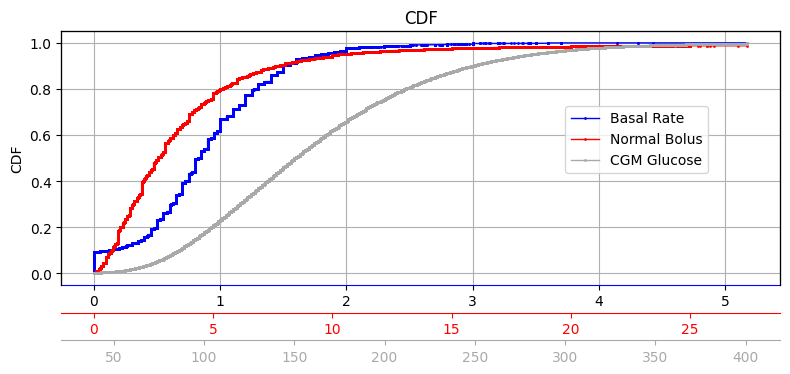

In [50]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot Basal Rate
#ax1.set_xlabel('Basal Rate')
ax1.set_ylabel('CDF')
cdf.plot_cdf(df_basal['Rate'].fillna(0), label='Basal Rate', color=drawing.colors['Basal'],ax=ax1)
#ax1.tick_params(axis='x', colors=drawing.colors['Basal'])
ax1.spines['bottom'].set_color(drawing.colors['Basal'])
ax1.xaxis.label.set_color(drawing.colors['Basal'])
ax1.set_xlabel(None)
#ax1.grid(False)
ax1.set_xlim()

# Create a twin Axes sharing the y-axis
ax2 = ax1.twiny()
cdf.plot_cdf(df_bolus['Normal'], label='Normal Bolus', color=drawing.colors['Bolus'],ax=ax2)
ax2.tick_params(axis='x', colors=drawing.colors['Bolus'])
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_color(drawing.colors['Bolus'])
ax2.spines['bottom'].set_position(('outward', 20))
ax2.xaxis.label.set_color(drawing.colors['Bolus'])
ax2.set_xlabel(None)
ax2.grid(False)


# Create another twin Axes sharing the y-axis
ax3 = ax1.twiny()
cdf.plot_cdf(df_cgm['GlucoseValue'], label='CGM Glucose', color=drawing.colors['CGM'],ax=ax3)
ax3.tick_params(axis='x', colors=drawing.colors['CGM'])
ax3.xaxis.set_ticks_position('bottom')
ax3.spines['bottom'].set_color(drawing.colors['CGM'])
ax3.spines['bottom'].set_position(('outward', 40))
ax3.xaxis.label.set_color(drawing.colors['CGM'])
ax3.set_xlabel(None)
ax3.grid(False)


#ax1.set_xlim(-.3,5)
#ax2.set_xlim(-2,30)
#ax3.set_xlim(-30,500)

ax1.set_title(None)
ax2.set_title(None)
ax3.set_title(None)
# Add legends
# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
handles = handles1 + handles2 + handles3
labels = labels1 + labels2 + labels3

# Create a single legend
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9, 0.7), ncol=1)
plt.suptitle(None)
plt.title('CDF')
#plt.show()
plt.tight_layout()
save_figure('CDFs')



In [51]:
print(f'{df_cgm.GlucoseValue.max()}, {df_cgm.GlucoseValue.min()}')
print(f'{df_bolus.Normal.max()}, {df_bolus.Normal.min()}')
print(f'{df_basal.Rate.max()}, {df_basal.Rate.min()}')

401.0, 39.0
27.4, 0.0
5.175, 0.0


Patient: 19, Start: 2015-07-03 21:31:11, End: 2015-07-03 23:31:11


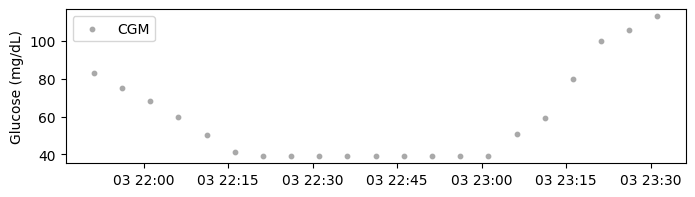

In [52]:
#draw data srrounding a 39 GlucoseValue
#sample = df_cgm.loc[df_cgm.GlucoseValue==39].sample()
sample = df_cgm.loc[1535501]
patient_id = sample.PtID
start = sample.datetime-timedelta(hours=1)
end   = sample.datetime+timedelta(hours=1)
print(f'Patient: {patient_id}, Start: {start}, End: {end}')
sub_frame = df_cgm.loc[(df_cgm.PtID==patient_id) & (df_cgm.datetime>=start) & (df_cgm.datetime<=end)]
importlib.reload(drawing)
plt.figure(figsize=(8,2)); ax=plt.gca()
drawing.drawCGM(ax,sub_frame.datetime,sub_frame.GlucoseValue)
save_figure('CGM_example_39')

In [53]:
#check if equally distributed
values_to_count = [39, 40, 400, 401]
value_counts = df_cgm[df_cgm['GlucoseValue'].isin(values_to_count)]['GlucoseValue'].value_counts()
print(value_counts.sort_index())

GlucoseValue
39.0     26739
40.0      4472
400.0     3433
401.0    44758
Name: count, dtype: int64


We see that there are much more 39 and 401 values compared to 40 and 401, therefore we can safely assume that 39 and 401 encode below and above readings.

In [54]:
df_cgm.loc[:,'GlucoseValue'].replace({39:40, 401:400},inplace=True)

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_57172/290133728.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cgm.loc[:,'GlucoseValue'].replace({39:40, 401:400},inplace=True)


### Daily Distributions

To understand if datetimes are local, we take a look at the daily moving averages of bolus, basal rates and cgm values.

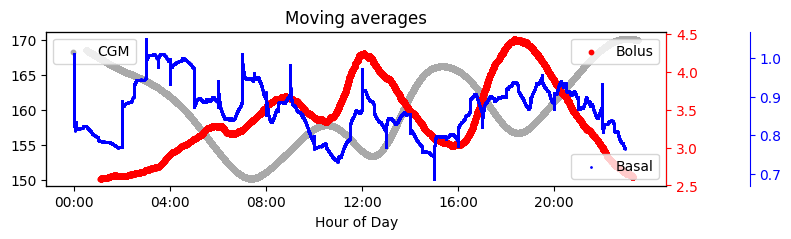

In [55]:
importlib.reload(drawing)
plt.figure(figsize=(8,2)); ax=plt.gca()
drawing.drawMovingAverage(ax, df_cgm, 'datetime', 'GlucoseValue', aggregator='mean', color=drawing.colors['CGM'], label='CGM')
ax.legend(loc='upper left')

# First twin axis (red)
twinax = ax.twinx()
drawing.drawMovingAverage(twinax, df_bolus.dropna(subset='Normal'), 'datetime', 'Normal', aggregator='mean', color='red', label='Bolus')
twinax.legend(loc='upper right')
twinax.spines['right'].set_color('red')
twinax.tick_params(axis='y', colors='red')
twinax.yaxis.label.set_color('red')

# Second twin axis (blue)
twinax2 = ax.twinx()
twinax2.spines['right'].set_position(('outward', 60))
drawing.drawMovingAverage(twinax2, df_basal, 'datetime', 'Rate', aggregator='mean', color='blue', label='Basal',s=1)
twinax2.legend(loc='lower right')
twinax2.spines['right'].set_color('blue')
twinax2.tick_params(axis='y', colors='blue')
twinax2.yaxis.label.set_color('blue')

plt.title('Moving averages')
save_figure('moving_averages')

CGM and Boluses are as expected showing charcteristic peaks around breakfast, lunch dinner, night.  However, basal rates show no specific pattern.  Probably this is because we have CSII not AID. The spikes might be because more standard basal rates are adjusted at these times. 

### Inspecting Basal Rates 

The unexpected lack of daily basal pattern made me wonder if there are problems with the basal rates. One reason for the could be that the datetimes are not correct. We would expect the same basal rate to repeat more or less from one day to the next. Let's plot basal rate and inspect and see if this holds true:

Dropdown(description='Patient ID', options=(2, 3, 5, 7, 8, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26,…

Output()

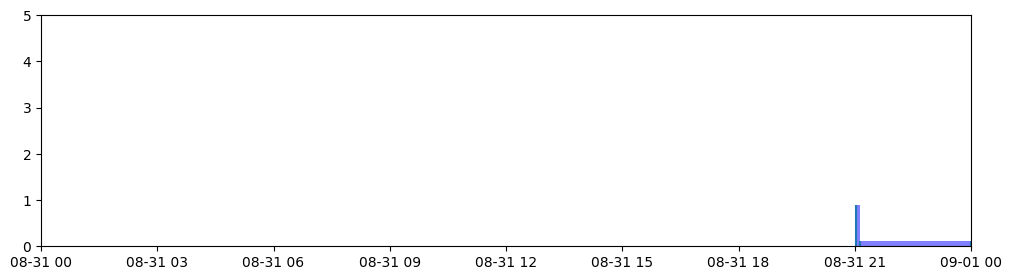

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import timedelta

patient_ids = df_basal.PtID.unique()

# Add dropdown 
dropdown = widgets.Dropdown(options=patient_ids, description='Patient ID')

slider = widgets.IntSlider(min=0, max=0, step=1, description='Index')

# Add buttons for navigation
button_prev = widgets.Button(description='Previous Day')
button_next = widgets.Button(description='Next Day')


def update_slider(*args):
    patient = dropdown.value
    df = df_basal.loc[df_basal.PtID == patient]
    num_days = (df['day'].max() - df['day'].min()).days
    slider.max = max(0, num_days)


def change_day(change):
    if change == 'next' and slider.value < slider.max:
        slider.value += 1
    elif change == 'prev' and slider.value > slider.min:
        slider.value -= 1


def plot_basal_data(patient, day):
    ax.cla()
    df = df_basal.loc[df_basal.PtID == patient]
    start = df.datetime.min().normalize() + timedelta(days=day)
    end = df.datetime.min().normalize() + timedelta(days=day + 1)
    df = df.loc[(df.datetime >= (start - timedelta(hours=2))) & (df.datetime < (end + timedelta(hours=2)))]
    print(f'Patient: {patient}, Day: {day} from ({start} - {end})')

    if df.empty:
        print('No data found for this patient and day.')
    else:
        drawing.drawBasal(ax, df.datetime, df.Rate)
        for single_date in pd.date_range(start=start, end=end, freq='D'):
            ax.axvline(single_date, color='red', linestyle='--', linewidth=0.5)
        ax.set_xlim((start, end))
        ax.set_ylim(0, 5)
    display(f)


# Button click handlers
button_prev.on_click(lambda _: change_day('prev'))
button_next.on_click(lambda _: change_day('next'))

dropdown.observe(update_slider, names='value')
update_slider()

f = plt.figure(figsize=(12, 3))
ax = plt.gca()

# Create an interactive output
out = widgets.interactive_output(plot_basal_data, {'day': slider, 'patient': dropdown})

# Layout for controls
controls = widgets.HBox([button_prev, slider, button_next])

# Display the dropdown, slider with buttons, and output
display(dropdown, controls, out)


# Now you can easily jump to the next/previous day! Let me know if you want any adjustments. 🚀


Yes, basal rates for the most part only change slightly from one day to the next day. Visualization of single basal rates does not work well because it displays from one to the next value only.

### Huge Basal Durations
Let's look at how basal rates and durations are distributed.

,PtID,datetime,Rate,Duration
17932,11,2015-07-09 15:30:00,0.6,1 days 08:30:00
68283,40,2014-07-02 00:00:00,1.5,1 days 07:47:21
68475,40,2014-10-22 00:00:00,1.5,1 days 00:05:06
77967,45,2014-11-08 23:14:56,0.9,1 days 07:36:37
81407,45,2015-08-26 00:00:00,0.8,278 days 15:43:10
81572,45,2015-09-24 00:00:00,0.8,249 days 16:43:10
118025,69,2015-01-17 11:23:46,2.0,1 days 12:36:14
144508,79,2015-07-23 07:30:27,0.9,15 days 08:20:01


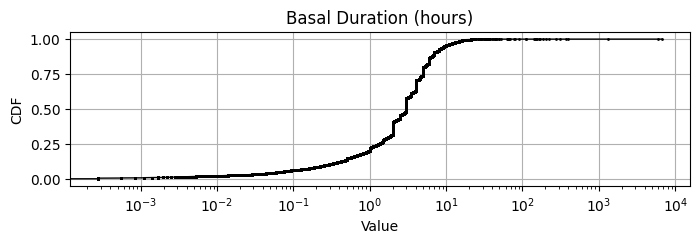

In [72]:
#cdfs
plt.figure(figsize=(8,2));ax=plt.gca()
cdf.plot_cdf(df_basal.Duration.dropna().dt.total_seconds()/3600,title='Basal Duration (hours)',ax=ax)
plt.xscale('log')

#plt.figure(figsize=(8,2));ax=plt.gca()
#df_basal['delivered'] = df_basal['Duration'].dt.total_seconds()/3600 * df_basal['Rate']
#cdf.plot_cdf(df_basal.delivered.dropna(),title='Basal Deliveries',ax=ax)
#plt.xscale('log')

df_basal.loc[(df_basal.Duration>timedelta(days=1)) & (df_basal.Rate>0)].head(8)[['PtID','datetime','Rate','Duration']]

Let's look at data around a very long duration

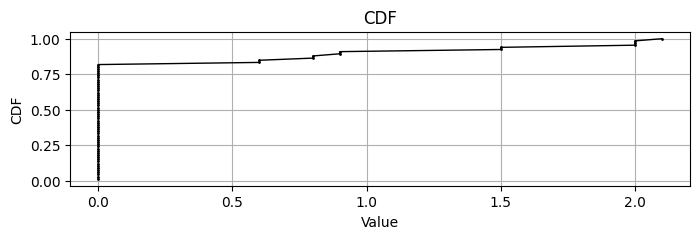

In [74]:
#plot cdf of basal Rates with durations >1 day
long_durations = df_basal.loc[(df_basal.Duration>timedelta(days=1))]
cdf.plot_cdf(long_durations.Rate)

Now, let's look at data surrounding rows with long duration. My hypothesis is that long durations are a result of missing data and were calculated retrospectively.

In [ ]:
import ipywidgets as widgets
from IPython.display import display

slider = widgets.IntSlider(min=0, max=len(long_durations) - 1, step=1, description='Index')
def display_surrounding_rows(index):
    sample = long_durations.iloc[index].name
    subset = pandas_helper.extract_surrounding_rows(df_basal, sample, 2, sort_by=['PtID', 'datetime'])
    subset = subset[['PtID', 'datetime', 'Rate', 'Duration']]
    display(subset)

# Create an interactive output
out = widgets.interactive_output(display_surrounding_rows, {'index': slider})

# Display the slider and the output
display(slider, out)

IntSlider(value=0, description='Index', max=65)

Output()

Observations
 - Often, long durations have a zero basal rate
 - Mostly the duraitons match the data gap of 1 or more days until next basal rate
 - Sometimes they overlap with the next datetime
 - Some are excessive e.g. >250 days: In these cases, the data might not even fall within the study period

### Boluses

## Collected Todos
- Why do extended and durations not match exactly?
- Do we need Dexcom times? When are these missing
- Are durations in ms or minutes, look at distributions


## Collected Questions
- How should we resolve basal duplicates with equal time and durations but different rates (e.g. scheduled)
- Should we use suspends over other events? And then, is NaN equal to a 0 basal rate? This is how we treated them in T1DExi
- Sometimes their durations don't match.
- Why do durations of basal duplicates sometimes match next 
- Should we exclude data before and after study start?
